In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_10_descriptive = get_prompt("descriptive", 10)
prompt_10_natural = get_prompt("natural", 10)

prompt_10_descriptive, prompt_10_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation. 10. Compute the radius of gyration over time for the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute RMSD and radius of gyration of both simulations. Compute SASA for the 300K simulation.')

In [3]:
llm_model = "claude-3-5-sonnet-20241022"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_10_descriptive)

Thought: Let's tackle this step by step. First, let's download the PDB file for 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that we have the PDB file, let's get the secondary structure assignments using ComputeDSSP.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_213446",
        "top_file": "1LYZ_213446",
        "target_frames": "all"
    }
}
```

Thought: Let's continue with finding the binding and active sites for lysozyme (1LYZ). First, we need to get its UniProt ID.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

Thought: Let's get the active and binding sites using the UniProt ID we just obtained.

Action:
```
{
    "action": "GetAllKnownSites",
    "action_input": {
        "query": "P17897",
        "primary_accession": "P17897"
    }
}
```

Thought: Let's continue with setting up and running the first simulati

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_213446: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_213446
 rec0_213449: dssp values for trajectory with id: 1LYZ_213446
 1LYZ_213506: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_213511: Initial positions for simulation sim0_213511
 sim0_213511: Basic Simulation of Protein 1LYZ_213506
 rec0_213518: Simulation trajectory for protein 1LYZ_213506 and simulation sim0_213511
 rec1_213518: Simulation state log for protein 1LYZ_213506 and simulation sim0_213511
 rec2_213518: Simulation pdb frames for protein 1LYZ_213506 and simulation sim0_213511
 rmsd_1LYZ: RMSD for 1LYZ
 fig0_214111: RMSD plot for 1LYZ
 rgy_rec0_213518: Radii of gyration per frame for rec0_213518
 fig0_214115: Plot of radii of gyration over time for rec0_213518
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_215002: Plot of SASA over time for 1LYZ
 top_sim0_215

In [16]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_213446"))

In [13]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_213446", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [15]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [12]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_213518")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_213511")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

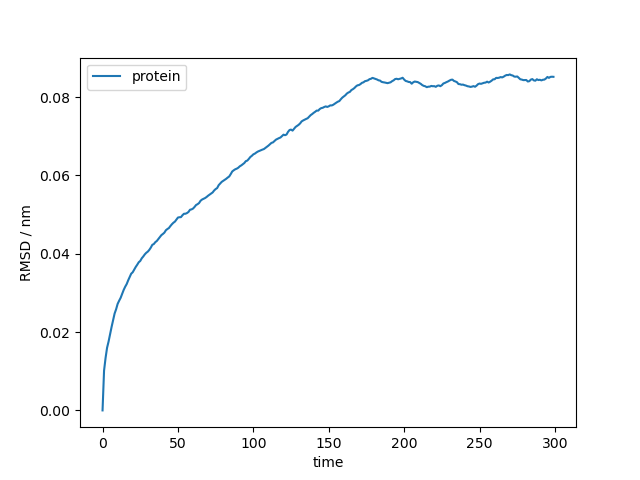

In [11]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_214111'))

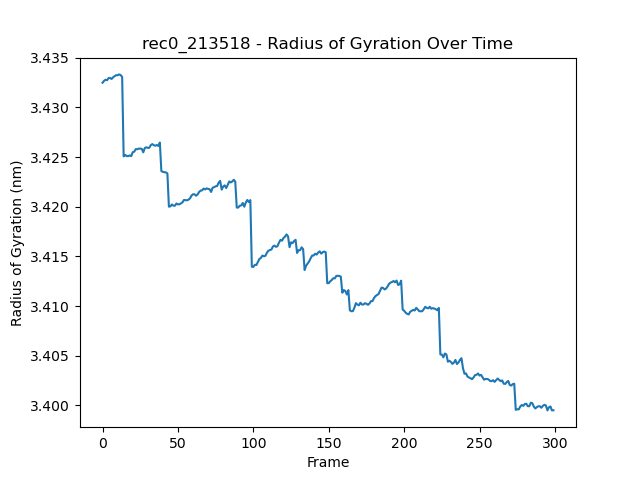

In [10]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_214115'))

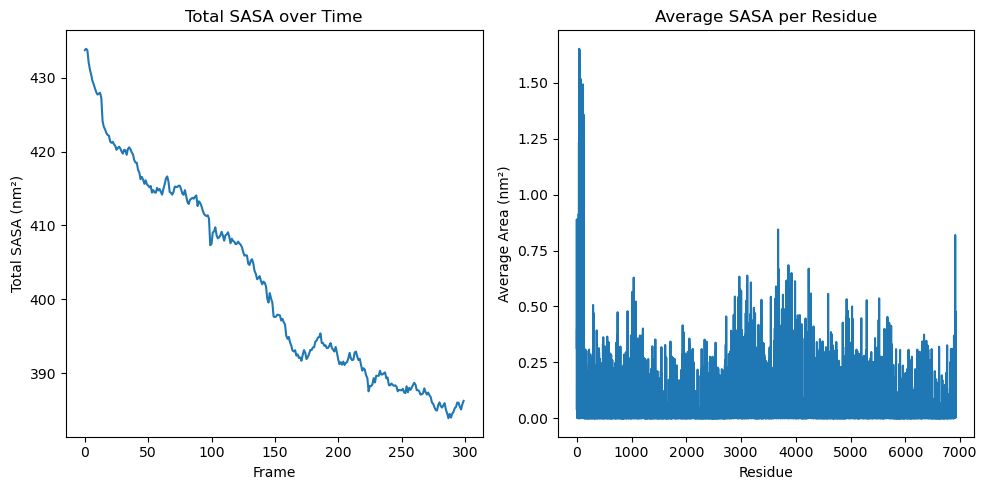

In [9]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_215002'))

In [8]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_215012")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_215008")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

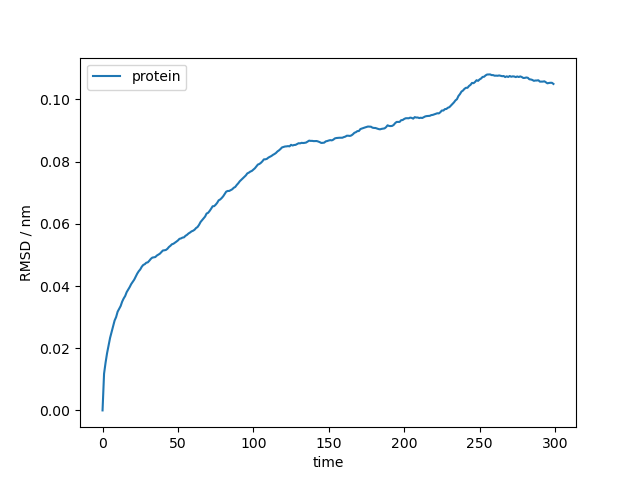

In [7]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_215454'))

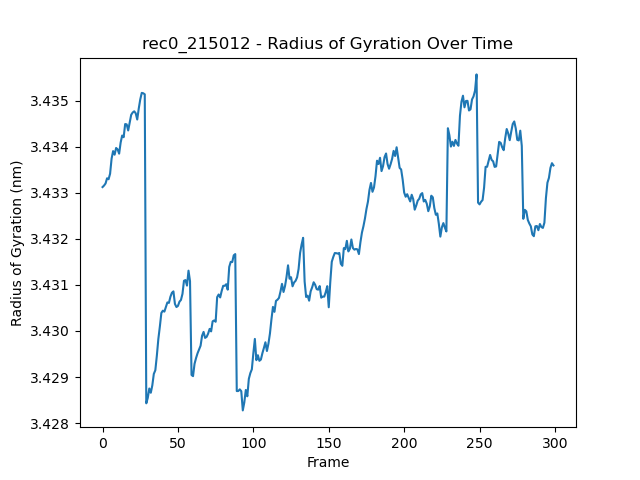

In [6]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_215457'))

In [17]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_10_natural)

Thought: I'll break this down into steps: 1) Download 1LYZ, 2) Get binding/active sites info, 3) Run simulations at both temperatures, 4) Analyze secondary structure, 5) Calculate RMSD, Rg, and SASA. Let's start by downloading the structure.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file, let's get information about binding and active sites for lysozyme before proceeding with simulations.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

Thought: Now that I have the UniProt ID, I can get comprehensive information about binding and active sites. Let's get all known sites.

Action:
```
{
    "action": "GetAllKnownSites",
    "action_input": {
        "query": "P17897",
        "primary_accession": "P17897"
    }
}
```

Thought: Let's analyze the secondary structure of the downloaded PDB structure before running simulations.

Action:
```
{
    "action":

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [18]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_215855: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_215855
 rec0_215905: dssp values for trajectory with id: 1LYZ_215855
 1LYZ_215915: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_215920: Initial positions for simulation sim0_215920
 sim0_215920: Basic Simulation of Protein 1LYZ_215915
 rec0_215924: Simulation trajectory for protein 1LYZ_215915 and simulation sim0_215920
 rec1_215924: Simulation state log for protein 1LYZ_215915 and simulation sim0_215920
 rec2_215924: Simulation pdb frames for protein 1LYZ_215915 and simulation sim0_215920
 top_sim0_220344: Initial positions for simulation sim0_220344
 sim0_220344: Basic Simulation of Protein 1LYZ_215915
 rec0_220348: Simulation trajectory for protein 1LYZ_215915 and simulation sim0_220344
 rec1_220348: Simulation state log for protein 1LYZ_215915 and simulation sim0_22

In [28]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_215855"))

In [27]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_215855", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [26]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [25]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_215924")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_215920")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

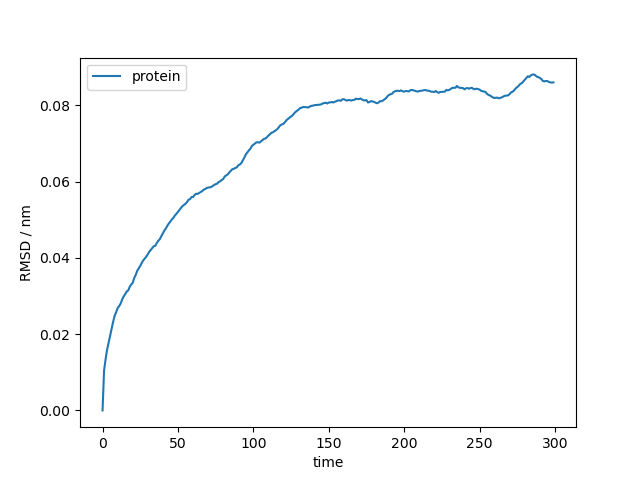

In [24]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_220748'))

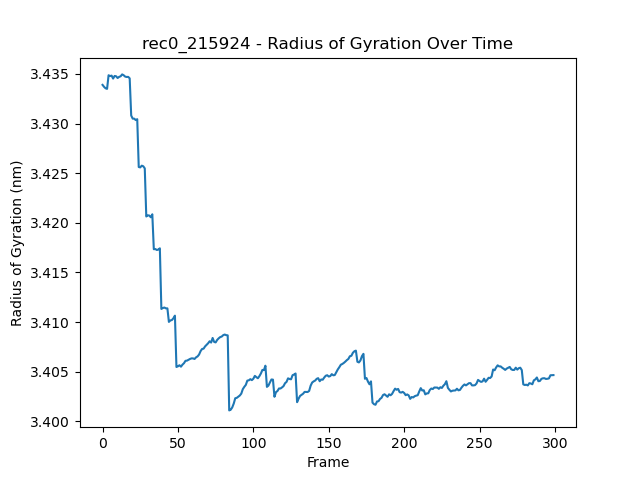

In [23]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_220752'))

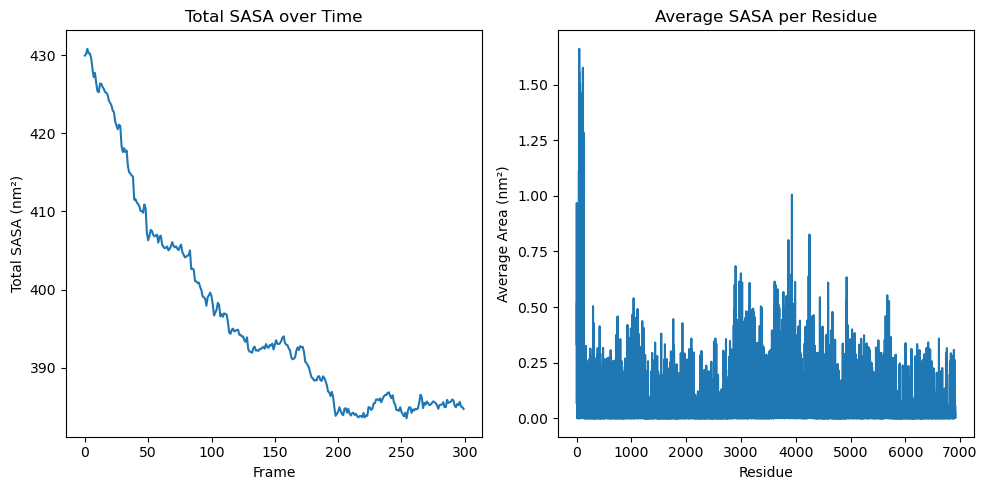

In [22]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_221640'))

In [21]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_220348")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_220344")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)

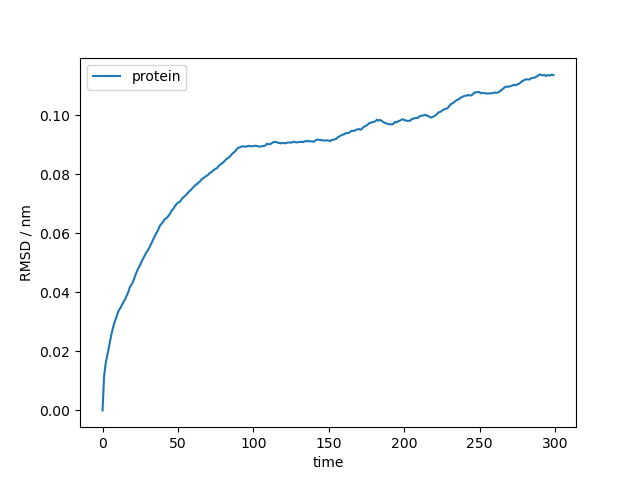

In [20]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_221644'))

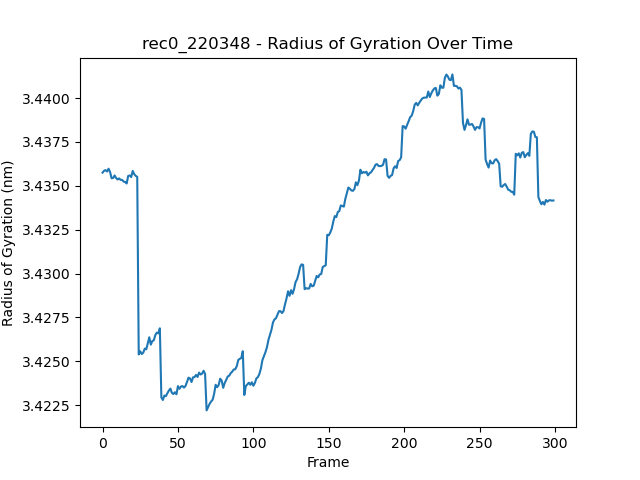

In [19]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_221648'))